<a href="https://colab.research.google.com/github/sanjay-thiyagarajan/super-resoluter/blob/main/SuperResolute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Super Resolution using ESRGAN

In [1]:
!pip install pytube

     |████████████████████████████████| 51kB 6.3MB/s 


In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from pytube import YouTube
import warnings
import cv2
warnings.filterwarnings("ignore")
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
!wget "http://people.csail.mit.edu/billf/project%20pages/sresCode/Markov%20Random%20Fields%20for%20Super-Resolution_files/100075_lowres.jpg" -O original.jpg

--2021-04-27 17:22:46--  http://people.csail.mit.edu/billf/project%20pages/sresCode/Markov%20Random%20Fields%20for%20Super-Resolution_files/100075_lowres.jpg
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75117 (73K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>]  73.36K  --.-KB/s    in 0.02s   

2021-04-27 17:22:46 (2.98 MB/s) - ‘original.jpg’ saved [75117/75117]



In [4]:
# Declaring Constants
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [5]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [23]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)
  #return image

In [7]:
hr_image = preprocess_image(IMAGE_PATH)

In [8]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

Saved as Original Image.jpg


In [9]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [10]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 35.205574


In [11]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

Saved as Super Resolution.jpg


In [36]:
!wget "https://www.bestprintingonline.com/help_resources/Image/Ducky_Head_Web_Low-Res.jpg" -O test.jpg
IMAGE_PATH = "test.jpg"

--2021-04-27 17:52:25--  https://www.bestprintingonline.com/help_resources/Image/Ducky_Head_Web_Low-Res.jpg
Resolving www.bestprintingonline.com (www.bestprintingonline.com)... 63.147.136.142
Connecting to www.bestprintingonline.com (www.bestprintingonline.com)|63.147.136.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38311 (37K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  37.41K  --.-KB/s    in 0.03s   

2021-04-27 17:52:25 (1.22 MB/s) - ‘test.jpg’ saved [38311/38311]



In [37]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [38]:
hr_image = preprocess_image(IMAGE_PATH)

In [39]:
lr_image = downscale_image(tf.squeeze(hr_image))

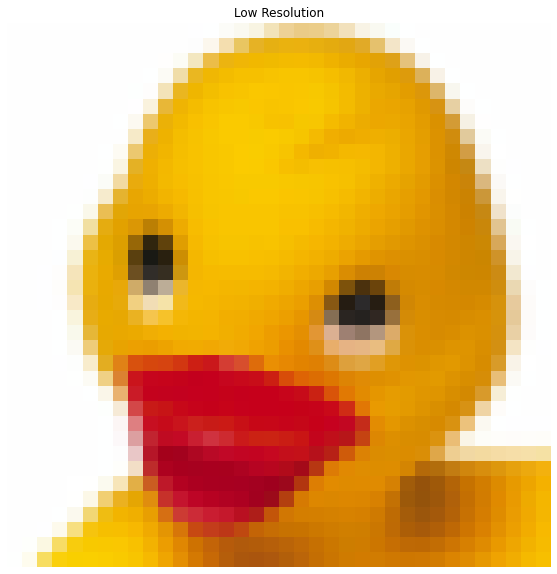

In [40]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [41]:
model = hub.load(SAVED_MODEL_PATH)

In [42]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.079201


In [43]:
type(tf.squeeze(fake_image))

tensorflow.python.framework.ops.EagerTensor

PSNR Achieved: 26.097332


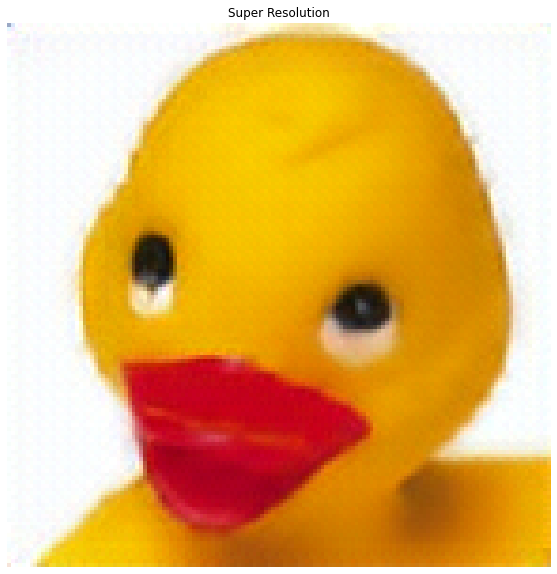

In [44]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

**Comparing Outputs size by side.**

PSNR: 26.097332


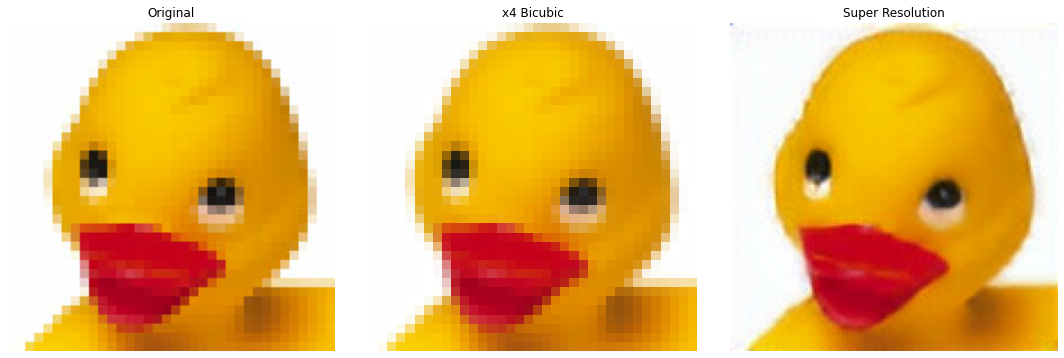

In [45]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [22]:
def FrameCapture(path):
  # Path to video file 
  vidObj = cv2.VideoCapture(path) 
  width = int(vidObj.get(3))
  height = int(vidObj.get(4))
  out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 20.0, (width, height))
  count = 0
  img_arr = []
  while True:
    ret, frame = vidObj.read()
    c = cv2.waitKey(1)
    if ret == True:
      pth = cv2.imwrite("frames/frame%d.jpg" % count, frame)
      hr_image = preprocess_image(f'frames/frame{count}.jpg')
      lr_image = downscale_image(tf.squeeze(hr_image))
      model = hub.load(SAVED_MODEL_PATH)
      fake_image = model(lr_image)
      fake_image = plot_image(tf.squeeze(fake_image))
      out.write(np.array(fake_image))
      count += 1
      if cv2.waitKey(1) & 0xFF == ord('s'): 
          break
    else:
      break
  vidObj.release()
  out.release()
  cv2.destroyAllWindows()
    

In [ ]:
url = 'https://www.youtube.com/watch?v=7DyJmwATVq4'
youtube = YouTube(url)
video = youtube.streams.get_lowest_resolution()
VIDEO_PATH = video.download()

In [ ]:
FrameCapture(VIDEO_PATH)